<a href="https://colab.research.google.com/github/TayyabKhan54/Machine-learning-project-/blob/main/ClassWork12_Advanced_Vision_VGG_ResNet_YOLO_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Work 12 — Advanced Vision & Object Detection (VGG, ResNet, YOLO, Tracking)

**Goal:** Understand the full pipeline from **pre-trained CNNs (VGG/ResNet)** to **object detection (YOLO)** and **object tracking**.

This notebook is written for **learning-by-doing**:
- Short explanations
- Small experiments
- Visual outputs (feature maps, predictions, boxes, IDs)

**Dataset(s):**
- CIFAR-10 (for transfer learning)
- COCO pretrained YOLO weights (for detection)
- Webcam stream (optional for real-time)

> **Run cells top-to-bottom.** If you are on Colab, webcam section is optional (use video file/image instead).

## 0) Setup

In [ ]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1) Load CIFAR-10 (for Transfer Learning Experiments)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Train: (50000, 32, 32, 3) (50000,)
Test : (10000, 32, 32, 3) (10000,)


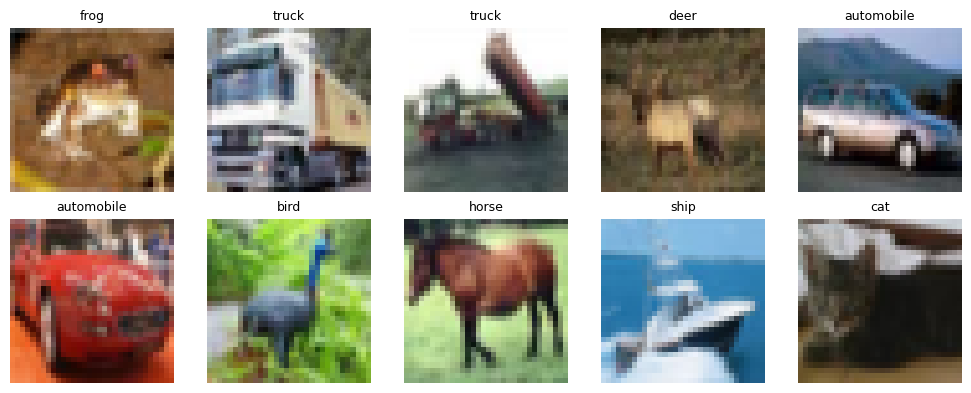

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

## 2) Preprocess Function for ImageNet Models
VGG/ResNet expect **224×224×3** input and special preprocessing.

In [ ]:
from tensorflow.keras.applications import vgg16, resnet50

IMG_SIZE = 224

def to_imagenet_batch(img_batch_uint8):
    imgs = tf.image.resize(img_batch_uint8, (IMG_SIZE, IMG_SIZE))
    imgs = tf.cast(imgs, tf.float32)
    return imgs

sample_imgs = x_train[:8]
sample_imgs_224 = to_imagenet_batch(sample_imgs)
print("Resized batch shape:", sample_imgs_224.shape)

Resized batch shape: (8, 224, 224, 3)


## 3) VGG16 — Load (Feature Extractor Mode)
Load VGG16 with `include_top=False` to get convolutional features.

In [ ]:
vgg_base = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
vgg_base.summary()

one = sample_imgs_224[:1]
one_pp = vgg16.preprocess_input(one)
vgg_feat = vgg_base(one_pp, training=False)
print("VGG feature shape:", vgg_feat.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

VGG feature shape: (1, 7, 7, 512)


## 4) VGG16 — Visualize Feature Maps (Early vs Deeper)
Compare early and deeper layer activations.

Block1 shape: (1, 224, 224, 64) | Block4 shape: (1, 28, 28, 512)


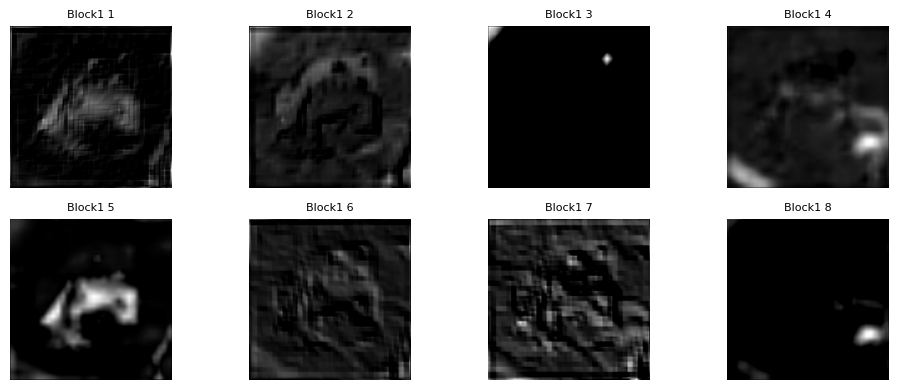

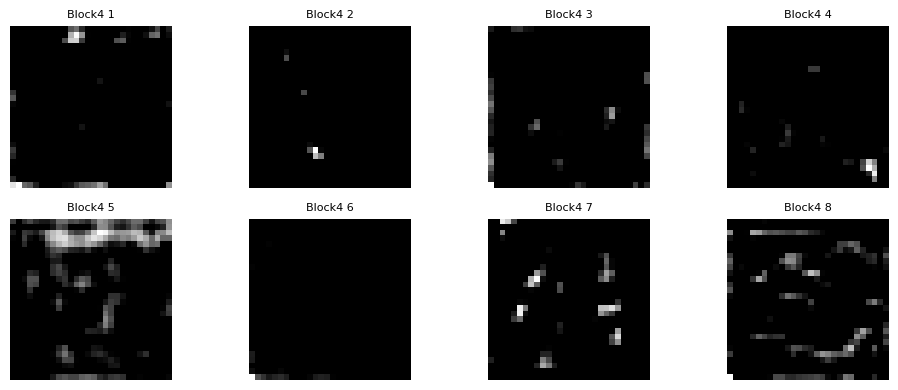

In [ ]:
layer_names = ["block1_conv2", "block4_conv3"]
outputs = [vgg_base.get_layer(n).output for n in layer_names]
vgg_probe = tf.keras.Model(inputs=vgg_base.input, outputs=outputs)

acts1, acts4 = vgg_probe(one_pp, training=False)

def show_maps(acts, title, n_maps=8):
    plt.figure(figsize=(10,4))
    for i in range(n_maps):
        plt.subplot(2,4,i+1)
        plt.imshow(acts[0,:,:,i], cmap="gray")
        plt.title(f"{title} {i+1}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Block1 shape:", acts1.shape, "| Block4 shape:", acts4.shape)
show_maps(acts1, "Block1")
show_maps(acts4, "Block4")

## 5) ResNet50 — Load (Feature Extractor Mode)
ResNet uses skip connections (residual learning).

In [ ]:
resnet_base = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
resnet_base.summary()

one_pp_r = resnet50.preprocess_input(one)
res_feat = resnet_base(one_pp_r, training=False)
print("ResNet feature shape:", res_feat.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

ResNet feature shape: (1, 7, 7, 2048)


## 6) Transfer Learning (Feature Extraction) on CIFAR-10
We train a small classifier head on top of a frozen ResNet base.
For class demo, we use a subset to run quickly.

In [ ]:
N_TRAIN = 1000
N_TEST  = 200

x_tr = x_train[:N_TRAIN]
y_tr = y_train[:N_TRAIN]
x_te = x_test[:N_TEST]
y_te = y_test[:N_TEST]

x_tr_224 = to_imagenet_batch(x_tr)
x_te_224 = to_imagenet_batch(x_te)

x_tr_pp = resnet50.preprocess_input(x_tr_224)
x_te_pp = resnet50.preprocess_input(x_te_224)

resnet_base.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = resnet_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
tl_model = tf.keras.Model(inputs, outputs)

tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

history = tl_model.fit(x_tr_pp, y_tr, validation_split=0.1, epochs=3, batch_size=64, verbose=1)

test_acc = tl_model.evaluate(x_te_pp, y_te, verbose=0)[1]
print("Transfer Learning Test Acc (subset):", round(test_acc, 4))

Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3592 - loss: 2.0381 - val_accuracy: 0.8100 - val_loss: 0.6217
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.8334 - loss: 0.4935 - val_accuracy: 0.8700 - val_loss: 0.4130
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9228 - loss: 0.2759 - val_accuracy: 0.8600 - val_loss: 0.4068
Transfer Learning Test Acc (subset): 0.835


## 7) Fine-Tuning (Unfreeze Last Layers)
Unfreeze the last ~30 layers and train with a smaller learning rate.

In [ ]:
resnet_base.trainable = True
for layer in resnet_base.layers[:-30]:
    layer.trainable = False

tl_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

history_ft = tl_model.fit(x_tr_pp, y_tr, validation_split=0.1, epochs=2, batch_size=64, verbose=1)

test_acc_ft = tl_model.evaluate(x_te_pp, y_te, verbose=0)[1]
print("Fine-Tuned Test Acc (subset):", round(test_acc_ft, 4))

Epoch 1/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8336 - loss: 0.4378 - val_accuracy: 0.8800 - val_loss: 0.3873
Epoch 2/2
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.9559 - loss: 0.1878 - val_accuracy: 0.8600 - val_loss: 0.3820
Fine-Tuned Test Acc (subset): 0.805


## 8) Plot Training Curves (Transfer Learning)

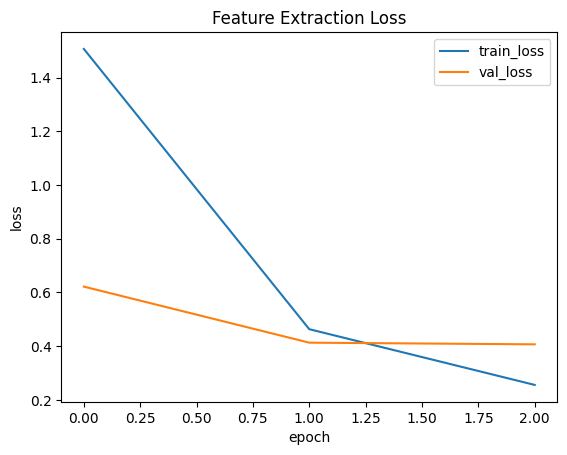

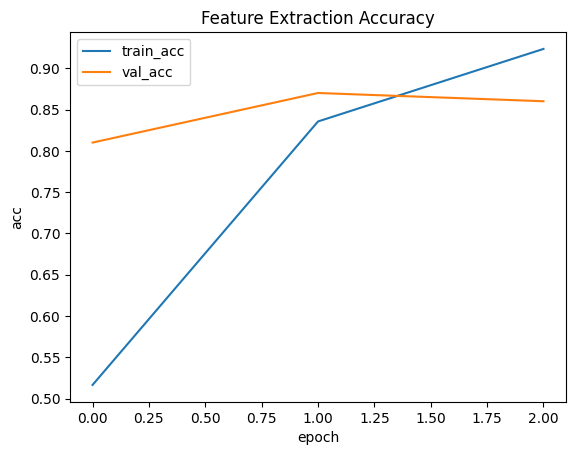

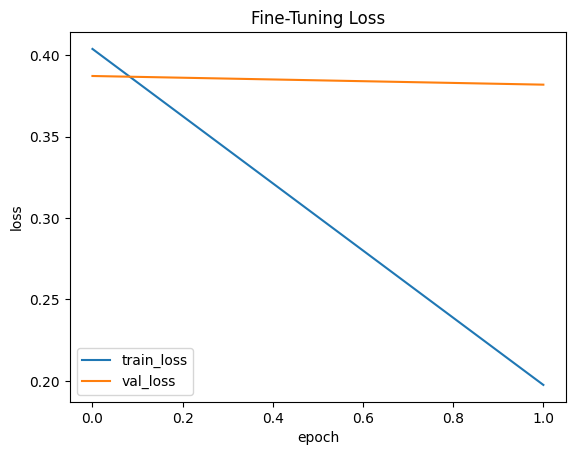

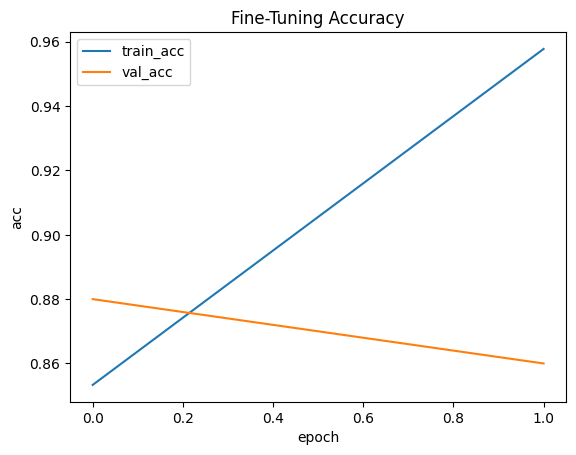

In [ ]:
def plot_history(h, title=""):
    plt.figure()
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.title(title + " Loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.show()

    plt.figure()
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.title(title + " Accuracy")
    plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
    plt.show()

plot_history(history, "Feature Extraction")
plot_history(history_ft, "Fine-Tuning")

## 9) YOLOv8 Object Detection (Image)
We use **Ultralytics YOLOv8**:
- install package
- load pretrained YOLO model
- run detection on an image
- draw bounding boxes

> If installation fails in your environment, skip this section.

In [ ]:
!pip -q install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.7 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


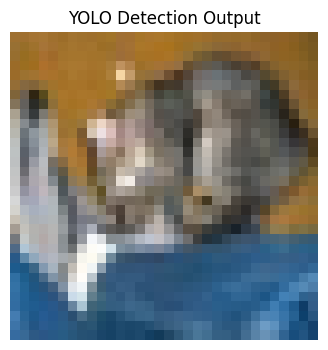

In [ ]:
from ultralytics import YOLO
import cv2

yolo = YOLO("yolov8n.pt")

# Use any RGB image (demo uses a CIFAR-10 image resized by YOLO internally)
img = x_test[0]  # uint8 RGB
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

results = yolo.predict(source=img_bgr, conf=0.25, verbose=False)

annotated = results[0].plot()  # BGR
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(annotated_rgb)
plt.title("YOLO Detection Output")
plt.axis("off")
plt.show()

## 10) Confidence Threshold Experiment
Compare detections at different confidence values.

In [ ]:
for conf in [0.25, 0.5]:
    res = yolo.predict(source=img_bgr, conf=conf, verbose=False)
    boxes = res[0].boxes
    n = 0 if boxes is None else len(boxes)
    print(f"conf={conf} -> detections={n}")

conf=0.25 -> detections=0
conf=0.5 -> detections=0


## 11) Object Tracking (Webcam/Video)
YOLOv8 supports basic tracking with `track()`.
- Local webcam: `source=0`
- Video file: `source="video.mp4"`

> Webcam access depends on your environment.

In [ ]:
# Option A (Local): track from webcam
# yolo.track(source=0, show=True, conf=0.25)

# Option B: track from a video file
# yolo.track(source="your_video.mp4", show=True, conf=0.25)

print("Tracking demo: uncomment one option above based on your environment.")

Tracking demo: uncomment one option above based on your environment.


## 12) IoU (Intersection over Union)
Compute IoU for two bounding boxes.
IoU is used in evaluation and NMS.

In [ ]:
def iou_xyxy(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h

    areaA = max(0, boxA[2]-boxA[0]) * max(0, boxA[3]-boxA[1])
    areaB = max(0, boxB[2]-boxB[0]) * max(0, boxB[3]-boxB[1])
    union = areaA + areaB - inter
    return inter / union if union > 0 else 0.0

box1 = (10, 10, 60, 60)
box2 = (30, 30, 80, 80)
print("IoU:", round(iou_xyxy(box1, box2), 4))

IoU: 0.2195


## Submission (Class Work 12)
Submit screenshots/outputs:
1) VGG feature maps (early vs deep)
2) ResNet summary (parameter comparison)
3) Transfer learning accuracy (feature extraction vs fine-tuning)
4) YOLO detection output on an image (with boxes)
5) Confidence threshold comparison (0.25 vs 0.50)
6) IoU calculation output
7) Tracking: screenshot (webcam/video) OR explain why it could not run in your environment